In [ ]:
import numpy as np
import pandas as pd
from epiweeks import Week
from prophet import Prophet
import matplotlib.pyplot as plt
from epiweeks import Week


# Creating a simple forecasting model

Here we will create a simple forecasting model using the `prophet` library.

## Downloading the Dengue dataset

Here we will build a simple univariate model using only dengue cases. We could use the Mosqlient library to fetch the data straight from the API, but instead we will download the prepared datasets made available by the sprint organizers. 

We will apply this model to the `MG` state.

In [43]:
df = pd.read_csv('dengue.csv.gz')

df = df.loc[df.uf == 'MG']

df['date'] = [Week.fromstring(str(x)).startdate() for x in df.epiweek]

df['date'] = pd.to_datetime(df['date'])

df.set_index('date', inplace = True)

df.head()

,year,epiweek,casos,geocode,regional,regional_geocode,macroregional,macroregional_geocode,uf,train_1,train_2,target_1,target_2
date,,,,,,,,,,,,,
2010-01-03,2010,201001,0,3110806,Itambacuri,31096,Nordeste,3111,MG,True,True,False,False
2010-01-03,2010,201001,0,3132404,Itajubá,31003,Sul,3101,MG,True,True,False,False
2010-01-03,2010,201001,0,3168903,São Gotardo,31082,Noroeste,3109,MG,True,True,False,False
2010-01-03,2010,201001,0,3155405,Juiz de Fora,31097,Sudeste,3107,MG,True,True,False,False
2010-01-03,2010,201001,0,3170602,Piumhi,31093,Sul,3101,MG,True,True,False,False


In [44]:
start_date = str(Week(2023, 40).startdate())
end_date = str(Week(2024, 23).startdate())
start_date, end_date

('2023-10-01', '2024-06-02')

Let's prepare the dataset, renaming the columns to match the `prophet` library requirements. The library requires a `ds` column for the date and a `y` column for the value to be predicted. 

In [45]:
df = df[['casos']]

df = df.resample('W').sum()

df.reset_index(inplace = True)

df = df.rename(columns = {'casos': 'y', 'date': 'ds'})
df.head()

,ds,y
0,2010-01-03,2794
1,2010-01-10,3729
2,2010-01-17,4656
3,2010-01-24,6195
4,2010-01-31,7179


To ensure data is always positive and at the same sclae, we will use the log of the number of cases. 

In [ ]:
df_train = df.loc[df.ds <= start_date][['ds', 'y']]

df_train['y'] = np.log1p(df_train['y'])

df_train.head()

,ds,y
0,2010-01-03,7.935587
1,2010-01-10,8.224164
2,2010-01-17,8.446127
3,2010-01-24,8.731659
4,2010-01-31,8.879055


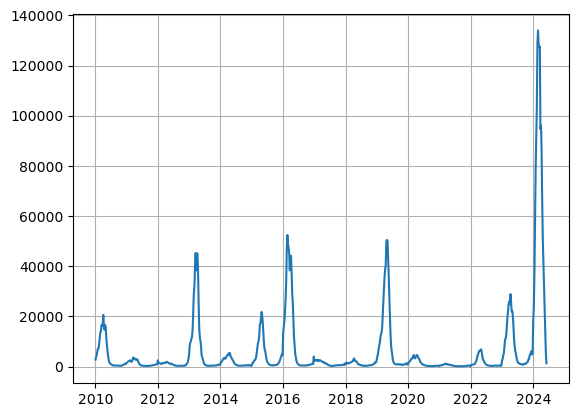

In [76]:
# Plot the training data
_, ax = plt.subplots()

ax.plot(df.ds, df.y, label = 'Casos')
ax.grid()
plt.show()

Let's define and train the model:

In [48]:
# Initialize and fit the model
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False, mcmc_samples = 100)
model.fit(df_train)

10:03:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:04:10 - cmdstanpy - INFO - CmdStan done processing.
10:04:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to l

## Making in-sample predictions

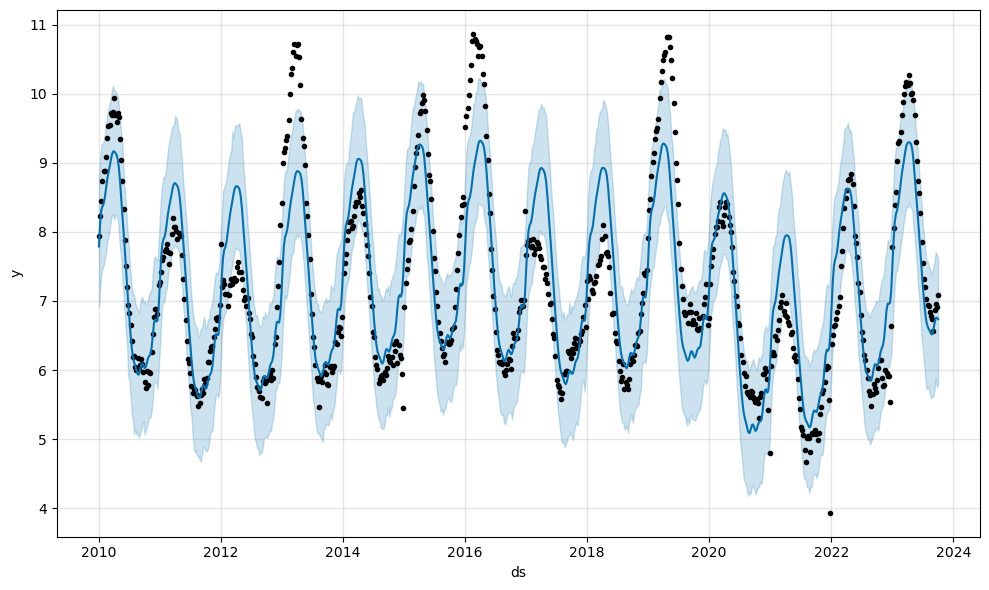

In [51]:
# Create a dataframe to hold predictions
dates = model.make_future_dataframe(periods=52, freq='W')
in_sample = dates[dates['ds'] <= start_date]

# Make predictions
forecast = model.predict(in_sample)
# Plot the forecast
fig1 = model.plot(forecast)

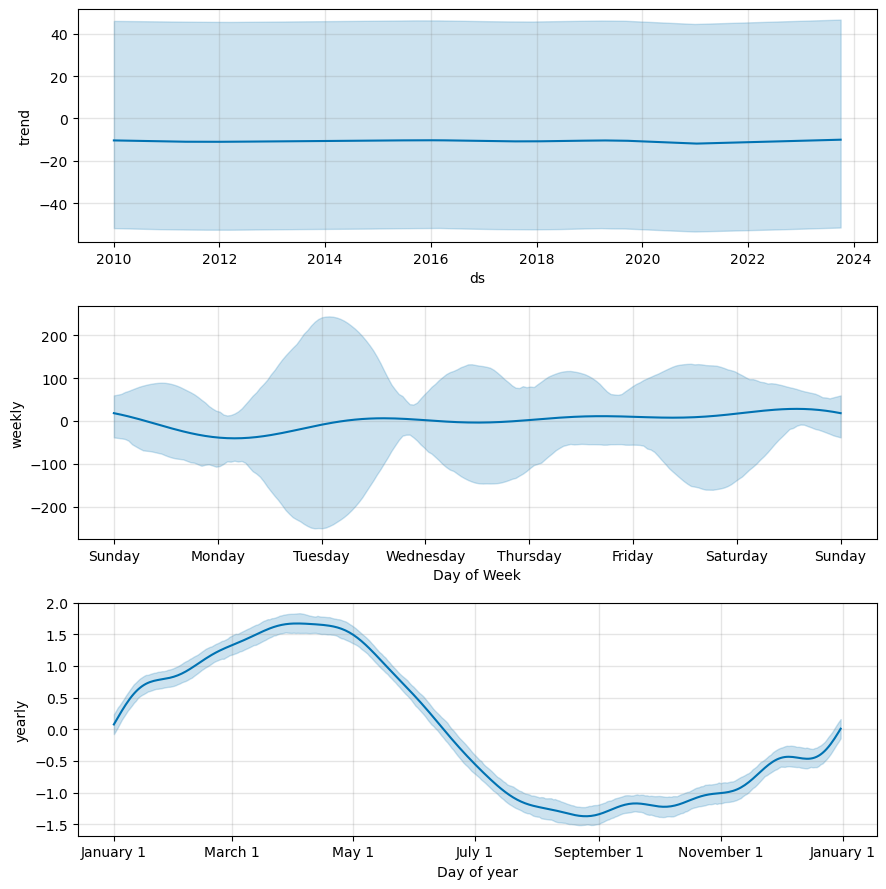

In [55]:
# plot the forecast
fig2 = model.plot_components(forecast)

## Using the model for forecasting:

In [ ]:
# Create a dataframe to hold predictions
future = dates[dates['ds'] > start_date]
samples = model.predictive_samples(future)
yhat_samples = samples['yhat']

In [ ]:
# Creating dataframe with the forecasted values and confidence intervals in the format required by the sprint
np.percentile(yhat_samples, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=1).T.shape
for_data = np.expm1(np.percentile(yhat_samples, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=1).T)

df_forecast = pd.DataFrame(for_data, columns = ['lower_95', 'lower_90', 'lower_80', 'lower_50',
                                  'pred', 'upper_50', 'upper_80', 'upper_90', 'upper_95'])

df_forecast['date'] =  pd.to_datetime(np.array(future['ds']))

df_forecast.head()

,lower_95,lower_90,lower_80,lower_50,pred,upper_50,upper_80,upper_90,upper_95,date
0,212.985147,256.226134,345.801870,525.959097,847.473863,1365.805192,2136.170671,2879.910843,3456.309881,2023-10-08
1,221.574320,288.991264,363.770840,551.579424,881.264989,1456.160767,2231.856923,2907.003577,3681.695545,2023-10-15
2,231.778021,297.424645,386.362836,631.375311,1032.361668,1702.675374,2586.550401,3433.219985,4164.631617,2023-10-22
3,262.861576,319.961356,412.418509,652.638121,1048.769517,1754.622040,2810.216960,3883.488183,4664.806117,2023-10-29
4,285.338952,370.142732,462.299022,699.058880,1165.659852,1858.161480,2820.211255,3665.036073,5243.597076,2023-11-05


## Uploading the forecasts to the Mosqlimate platform

The code below is used since my api_key is saved on an .env file: 

In [61]:
import os
import json
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the environment variables
api_key = os.getenv('API_KEY')


### 1. Upload your model. If you have done this already, you can skip to step 2.

In [62]:
from mosqlient import upload_model

name = "2025 sprint test - Prophet "
description = "test model for 2025 sprint test model for 2025 sprint test model for 2025 sprint test model for 2025 sprint"
repository = "https://github.com/Mosqlimate-project/sprint-template-2025/"
implementation_language = "Python"
disease = "dengue"
temporal = True
spatial = True
categorical = False
adm_level = 1
time_resolution = "week"
sprint = False

model = upload_model(
    api_key=api_key,
    name=name,
    description=description,
    repository=repository,
    implementation_language=implementation_language,
    disease=disease,
    temporal=temporal,
    spatial=spatial,
    categorical=categorical,
    adm_level=adm_level,
    time_resolution=time_resolution,
    sprint=sprint
)
model.dict()

{'id': 67,
 'name': '2025 sprint test - Prophet ',
 'description': 'test model for 2025 sprint test model for 2025 sprint test model for 2025 sprint test model for 2025 sprint',
 'author': {'user': {'name': 'Zuilho Segundo', 'username': 'ZuilhoSe'},
  'institution': None},
 'repository': 'https://github.com/Mosqlimate-project/sprint-template-2025/',
 'implementation_language': {'language': 'Python'},
 'disease': 'dengue',
 'categorical': False,
 'spatial': True,
 'temporal': True,
 'ADM_level': 1,
 'time_resolution': 'week',
 'sprint': False}

### 2. Upload the predictions.

You can now upload the forecast using the function `upload_predictions` from the `mosqlient` package. 


The function has the following parameters:

- `model_id`: int, The id number of the model registered on the platform. 
- `description`: str, A brief description of the prediction. 
- `commit`": str, The commit number associated with the model that generated the prediction.
- `predict_date`: str, The day of the prediction. 
- `prediction`: pd.DataFrame, A  dataframe that contains the data. It must contain the following columns: [`date`, `lower_95`, `upper_95`, `lower_90`, `upper_90`, `lower_80`, `upper_80`, `lower_50`, `upper_50`, `preds`, `adm_{adm_level}`].
- `api_key`: str, your personal api key. 

When registering your model, you need to provide the `ADM Level` of the output predictions. If your model has an ADM level—1, state level, then your predictions must contain the `adm_1` column. The other adm columns can be set as NA values.

Let's add the adm level in out predictions.:

In [63]:
df_forecast['adm_1'] = 'MG'

df_forecast.head()

,lower_95,lower_90,lower_80,lower_50,pred,upper_50,upper_80,upper_90,upper_95,date,adm_1
0,212.985147,256.226134,345.801870,525.959097,847.473863,1365.805192,2136.170671,2879.910843,3456.309881,2023-10-08,MG
1,221.574320,288.991264,363.770840,551.579424,881.264989,1456.160767,2231.856923,2907.003577,3681.695545,2023-10-15,MG
2,231.778021,297.424645,386.362836,631.375311,1032.361668,1702.675374,2586.550401,3433.219985,4164.631617,2023-10-22,MG
3,262.861576,319.961356,412.418509,652.638121,1048.769517,1754.622040,2810.216960,3883.488183,4664.806117,2023-10-29,MG
4,285.338952,370.142732,462.299022,699.058880,1165.659852,1858.161480,2820.211255,3665.036073,5243.597076,2023-11-05,MG


To transform a dataframe in the json string format accepted by the function, just use the command: 

df_for.to_json(orient = 'records', date_format = 'iso')`. 

In [64]:
from mosqlient import upload_prediction

res = upload_prediction(
            model_id = 61, 
            description = 'test for sprint 2025 preds of the arima model in MG', 
            commit = 'df1c695eaa5af5edb125a9d4ec72a4d2528c7411',
            predict_date = '2025-04-24', 
            prediction = df_forecast,
            adm_1="MG",
            api_key = api_key)

If the prediction's upload worked you will receive a json output as shown above. Also you will see it in your [predictions page](https://api.mosqlimate.org/predictions/).

The `mosqlient` package also contains a Class to compare your predictions called `Scorer`. A full documentation of the functions of this class can be found [here](https://github.com/Mosqlimate-project/mosqlimate-client/blob/main/docs/tutorials/scoring.ipynb). 

But in summary it takes as input the parameters: 
* `df_true`: pd.DataFrame. DataFrame with the columns `date` and `casos`. 
* `ids`: list[int] | None. List of the predictions already registered in the platform that you want to compare your model with. 
* `preds`: pd.DataFrame. Preds to be compared with df_true. It must contains the columns: `date`, `lower_95`, `upper_95`, `lower_90`, `upper_90`, `lower_80`, `upper_80`, `lower_50`, `upper_50`, `preds`, `adm_{adm_level}`.
  
Let's compare the `df_for` with what happened during the period. 

In [70]:
df_true = df.loc[(df.ds >= '2024-01-07') & (df.ds <= '2024-01-28')].rename(columns = {'y':'casos'})

# rename ds to date
df_true = df_true.rename(columns = {'ds':'date'})

df_true

,date,casos
731,2024-01-07,24030
732,2024-01-14,37131
733,2024-01-21,56826
734,2024-01-28,78217


In [71]:
df_forecast.dtypes

lower_95           float64
lower_90           float64
lower_80           float64
lower_50           float64
pred               float64
upper_50           float64
upper_80           float64
upper_90           float64
upper_95           float64
date        datetime64[ns]
adm_1               object
dtype: object

In [72]:
from mosqlient.scoring import Scorer

score = Scorer(api_key=api_key, df_true = df_true, pred = df_forecast, conf_level=0.90)

Let's see a plot comparing the cases and predictions:

In [73]:
score.plot_predictions()

alt.LayerChart(...)

Let's see the CRPS score of the model: 

In [74]:
score.crps

({'pred': date
  2024-01-07    15494.123400
  2024-01-14    25637.880265
  2024-01-21    43138.019533
  2024-01-28    63259.205953
  dtype: float64},
 {'pred': 36882.30728758838})

In [75]:
score.plot_crps()

alt.VConcatChart(...)